## Voyager 2

Example data taken on 2018-10-22 during MARS receiver testing, using the Breakthrough Listen backend.

Data recorded over full bandwidth of MARS receiver, here we have extracted a small bandwidth around the Voyager2 telemetry signal.

Spectral data product has 2.79 Hz resolution, 18.25 s time integrations.

*Notebook run from blc12*

In [1]:
%matplotlib inline

In [2]:
import blimpy as bl
import pylab as plt
import numpy as np

plt.rcParams['font.size'] = 12

## Dynamic spectra data

Data is stored in filterbank format, which can be loaded using [blimpy](https://github.com/ucberkleyseti/blimpy):

In [187]:
filename = '/datax2/users/dancpr/voyager2_hires_2018.10.22.h5'
a = bl.Waterfall(filename)
a.info()


--- File Info ---
    telescope_id :                               -1
        az_start :                              0.0
           nbits :                               32
            fch1 :                8575.319999076426
       data_type :                                1
          nchans :                            19328
           ibeam :                               -1
      machine_id :                               20
           tsamp :               18.253611007999822
            foff :           2.7939677238464355e-06
DIMENSION_LABELS :   ['frequency' 'feed_id' 'time']
         src_raj :                       20:01:07.8
         src_dej :                      -54:08:47.8
          tstart :                58413.24518518519
          nbeams :                                1
     source_name :                       VOYAGER2_R
        za_start :                              0.0
     rawdatafile : guppi_58413_21184_051767_VOYAGER2_R_0001.0000.fil
            nifs :          

Plotting and showing dynamic spectra, we can see the signal drifting due to doppler acceleration (LO does not correct for LSRK)

extracting integration 0...


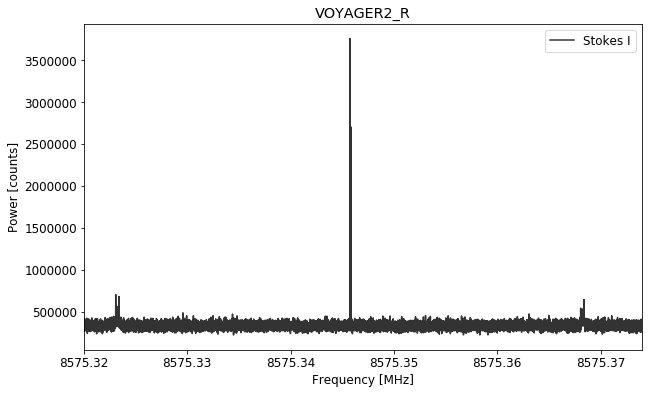

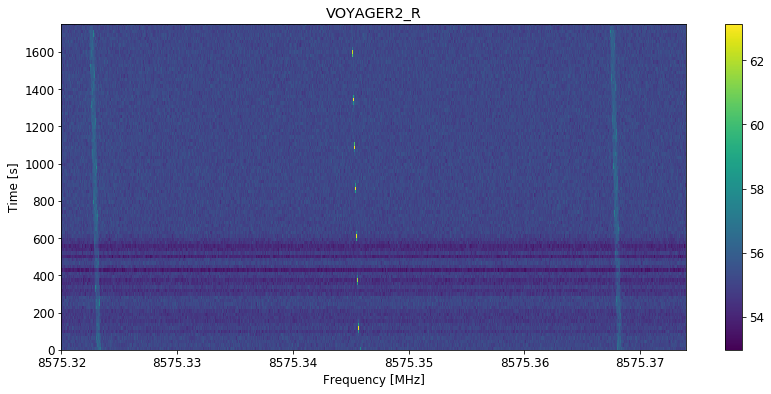

In [184]:
plt.figure(figsize=(10, 6))
a.plot_spectrum()

plt.figure(figsize=(14, 6))
a.plot_waterfall()

### Extract sidebands and zoom

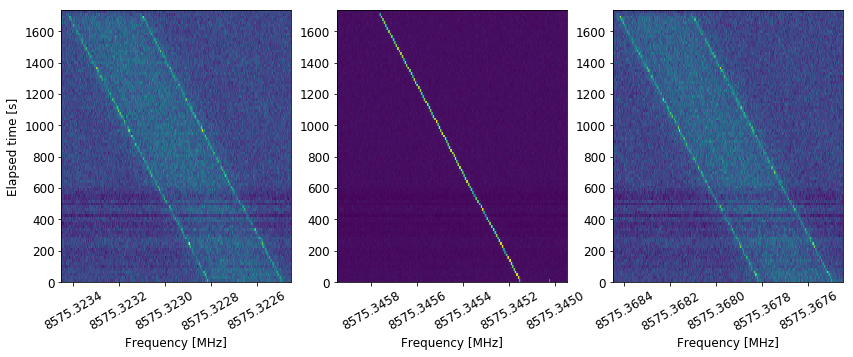

In [189]:
fc_cw   = 8575.34545  # Center freq of transmission
sb_sep  = 0.0225      # Sideband separation from carrier in MHz
sb_bw   = 0.001       # Sideband bandwidth
plot_bw = sb_bw / 2   # Plotting bandwidth
t = a.timestamps

# Calculate center freq of sidebands
fc_lsb = fc_cw - sb_sep
fc_usb = fc_cw + sb_sep

# Extract data
f_cw,   d_cw   = a.grab_data(f_start=fc_cw-plot_bw, f_stop=fc_cw+plot_bw)
f_lsb,  d_lsb  = a.grab_data(f_start=fc_lsb-plot_bw, f_stop=fc_lsb+plot_bw)
f_usb,  d_usb  = a.grab_data(f_start=fc_usb-plot_bw, f_stop=fc_usb+plot_bw)

# Plot
def plot_waterfall(t, f, d):
    t_elapsed = (t[-1] - t[0]) * 86400
    plt.imshow(d[::-1], aspect='auto', extent=(f[-1], f[0], 0, t_elapsed))
    plt.xticks(rotation=30)
    plt.xlabel("Frequency [MHz]")
    
plt.figure(figsize=(14, 5))
plt.subplot(1,3,1)
plt.ylabel("Elapsed time [s]")
plot_waterfall(t, f_lsb, d_lsb)
plt.subplot(1,3,2)
plot_waterfall(t, f_cw, d_cw)
plt.subplot(1,3,3)
plot_waterfall(t, f_usb, d_usb)

### Raw voltage data

Raw voltage data for a 2.92 MHz subband was recorded about the Voyager signal. It is stored in Guppi RAW format, as 8-bit integers. This can also be loaded using blimpy.

In [3]:
raw_filename = '/datax2/users/dancpr/voyager_2018.10.22.raw'
raw = bl.GuppiRaw(raw_filename)

In [4]:
raw_header0, raw_data0 = raw.read_next_data_block()

Data shape is (1, 524288, 2), and dtype is presented as complex64 (but stored as 8-bit in file)

Axes are (channel, time sample, polarization). You can iterate over multiple blocks of data to get more time samples if required, until the end of the file.

In [14]:
raw_data0.shape

(1, 524288, 2)

We can compute the spectrum from these data

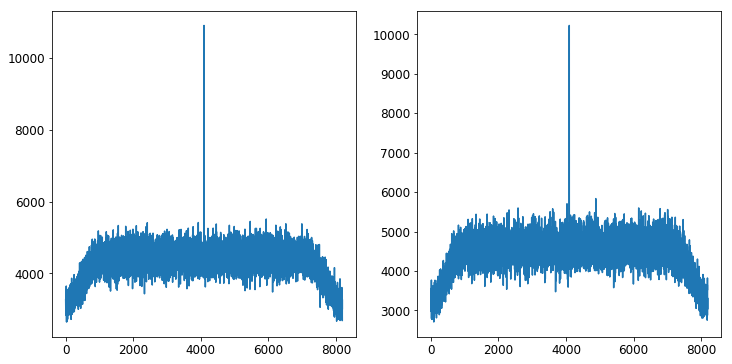

In [39]:
dx = raw_data0.squeeze()[:, 0]
dy = raw_data0.squeeze()[:, 1]

n_chans = 8192

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
Dx = np.abs(np.fft.fftshift(np.fft.fft(dx)))
Dx = Dx.reshape([n_chans, -1]).mean(axis=-1)
plt.plot(Dx)

plt.subplot(1,2,2)
Dy = np.abs(np.fft.fftshift(np.fft.fft(dy)))
Dy = Dy.reshape([n_chans, -1]).mean(axis=-1)
plt.plot(Dy)

We can use multiple blocks to integrate the spectrum down:

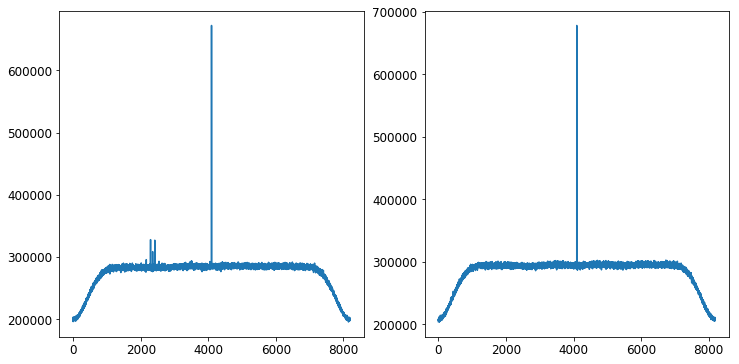

In [69]:
n_chans = 8192
n_ints  = 64

raw.reset_index()

x, y = np.zeros(n_chans), np.zeros(n_chans)
for idx in range(n_ints):
    h, d = raw.read_next_data_block()
    dx = d.squeeze()[:, 0]
    dy = d.squeeze()[:, 1]
    Dx = np.abs(np.fft.fftshift(np.fft.fft(dx)))
    Dx = Dx.reshape([n_chans, -1]).mean(axis=-1)
    Dy = np.abs(np.fft.fftshift(np.fft.fft(dy)))
    Dy = Dy.reshape([n_chans, -1]).mean(axis=-1)
    x += Dx
    y += Dy

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(x)

plt.subplot(1,2,2)
plt.plot(y)